In [4]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import wandb
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from m3util.viz.layout import layout_fig

from dl_utils.analysis.confusion_matrix import show_multiple_cm, confusion_matrix
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, find_last_epoch_file
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, xcit_small, fpn_resnet50_classification, densenet161_
from dl_utils.training.trainer import Trainer, accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ds_path_info = {'imagenet': '../../datasets/imagenet_v5_rot_10m_fix_vector.h5',
                'noise': '../../datasets/noise_v5_rot_1m_fix_vector.h5',
                'atom': '../../datasets/atom_v5_rot_1m_fix_vector.h5',
                'viz_dataloader': False}

training_specs = {'batch_size': 512, 
                  'num_workers': 12, 
                  'device_ids': [0, 1], 
                  'shuffle': True,
                  'learning_rate': 1e-3,
                  'epochs': 1000,
                  'validation_times': 200,
                  'training_image_count': 10000000*20, # 20 epochs of 10 million images of full imagenet dataset
                  'efficient_print': True,
                  'model_path': '../../models/ResNet50/',
}

config = {'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
    
# wandb_specs = {'config': config,
#                 'project': 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning',
#                 'entity': 'yig319',
#                 'group': 'benchmark',
#                 'save_code': True,
                # 'resume': 'allow'}

model = resnet50_(in_channels=3, n_classes=17)
task_name = '03132025-ResNet50-benchmark'

In [ ]:
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=torch.device('cpu')))

training_specs['epoch_start'] = 15
training_specs['ds_size'] = 10000000
training_specs['folder_name'] = '09112024-resnet50-dataset_v5_size-10m'

# model, history = benchmark_task(task_name, model, training_specs=training_specs, ds_path_info=ds_path_info, wandb_specs=wandb_specs)

In [ ]:
    # symmetry classes
    symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
    label_converter = list_to_dict(symmetry_classes)

    # imagenet
    imagenet_ds = hdf5_dataset(ds_path_info['imagenet'], folder='imagenet', transform=transforms.ToTensor())
    ratio = training_specs['ds_size'] * (1/0.8) / len(imagenet_ds)
    imagenet_ds, _ = split_train_valid(imagenet_ds, ratio, seed=42)
    train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42) 
    train_dl = DataLoader(train_ds, batch_size=training_specs['batch_size'], shuffle=True, num_workers=training_specs['num_workers'])
    valid_dl = DataLoader(valid_ds, batch_size=training_specs['batch_size'], shuffle=False, num_workers=training_specs['num_workers'])

    # noise
    noise_ds = hdf5_dataset(ds_path_info['noise'], folder='noise', transform=transforms.ToTensor())
    ratio = np.min((training_specs['ds_size'] / len(noise_ds), 1)) # avoid larger than 1
    noise_ds, rest_ds = split_train_valid(noise_ds, ratio, seed=42)
    noise_dl = DataLoader(noise_ds, batch_size=training_specs['batch_size'], shuffle=False, num_workers=training_specs['num_workers'])
    
    # atom
    atom_ds = hdf5_dataset(ds_path_info['atom'], folder='atom', transform=transforms.ToTensor())
    ratio = np.min((training_specs['ds_size'] / len(atom_ds), 1)) # avoid larger than 1
    atom_ds, rest_ds = split_train_valid(atom_ds, ratio, seed=42)
    atom_dl = DataLoader(atom_ds, batch_size=training_specs['batch_size'], shuffle=False, num_workers=training_specs['num_workers'])
    
    # visualization
    if ds_path_info['viz_dataloader']:
        viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
        viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')
        viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')
        viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

    # model 
    device = torch.device('cuda:{}'.format(training_specs['device_ids'][0]))
    if len(training_specs['device_ids']) > 1:
        model = torch.nn.DataParallel(model, device_ids=training_specs['device_ids'])
    else:
        model = model.to(device)
        
    # wandb
    NAME = task_name + '-dstaset_size=' + str(training_specs['ds_size'])
    if wandb_specs != {}:
        wandb.login()
        wandb.init(project=wandb_specs['project'], entity=wandb_specs['entity'], name=NAME, id=NAME, group=wandb_specs['group'], save_code=wandb_specs['save_code'], config=wandb_specs['config'], resume=wandb_specs['resume'])
        training_specs['wandb_record'] = True
    else:
        training_specs['wandb_record'] = False
        
    # training
    lr = training_specs['learning_rate']
    if 'epoch_start' in training_specs:
        epoch_start = training_specs['epoch_start']
    else:
        epoch_start = 0
    epochs = training_specs['training_image_count'] // len(train_ds) - epoch_start # training epochs based on the number of images in the dataset 
    valid_per_epochs = int(np.max((1, epochs / training_specs['validation_times']))) # validation times based on the number of epochs, and at least 1
    early_stopping_patience = np.max((5, valid_per_epochs+2)) # early stopping patience based on the number of validation times, and at least 2
    efficient_print = training_specs['efficient_print']
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
    metrics = [accuracy]  # You can add more metrics if needed
    if training_specs['folder_name'] == 'default':
        folder_name = NAME
    else:
        folder_name = training_specs['folder_name']
    
    trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, device=device, save_per_epochs=valid_per_epochs, model_path=training_specs['model_path']+folder_name+'/', early_stopping_patience=early_stopping_patience, efficient_print=efficient_print) # 

    history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=valid_per_epochs, valid_dl_list=[valid_dl, noise_dl, atom_dl], valid_dl_names=['', 'noise', 'atom'], wandb_record=training_specs['wandb_record'])
    wandb.finish()
    
    print(history)
    trainer.plot_training_metrics()
    

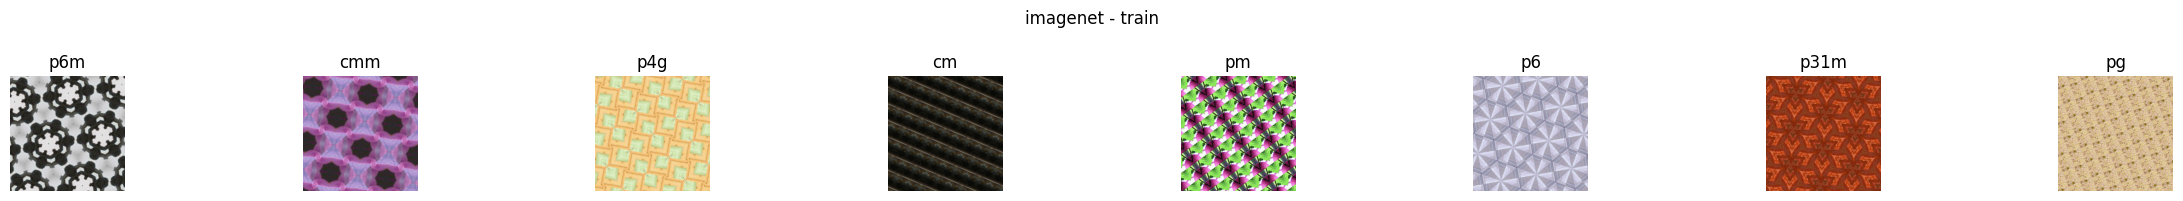

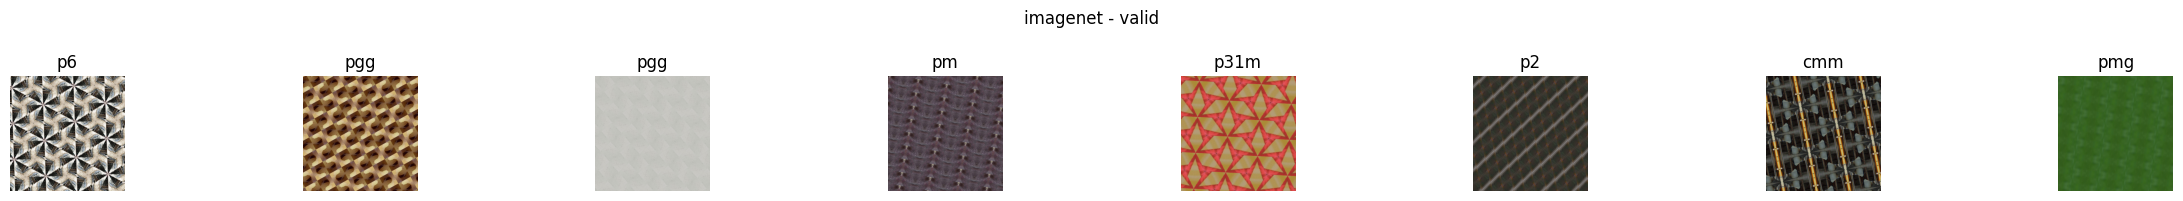

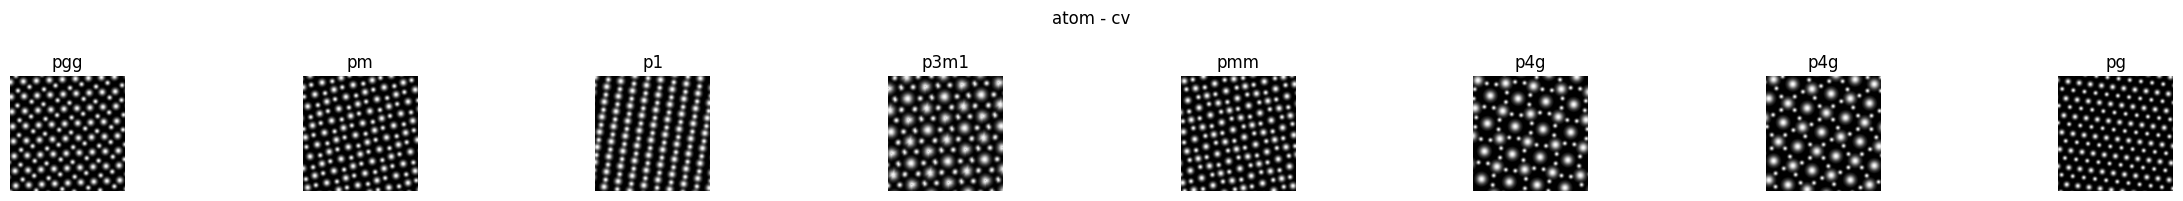

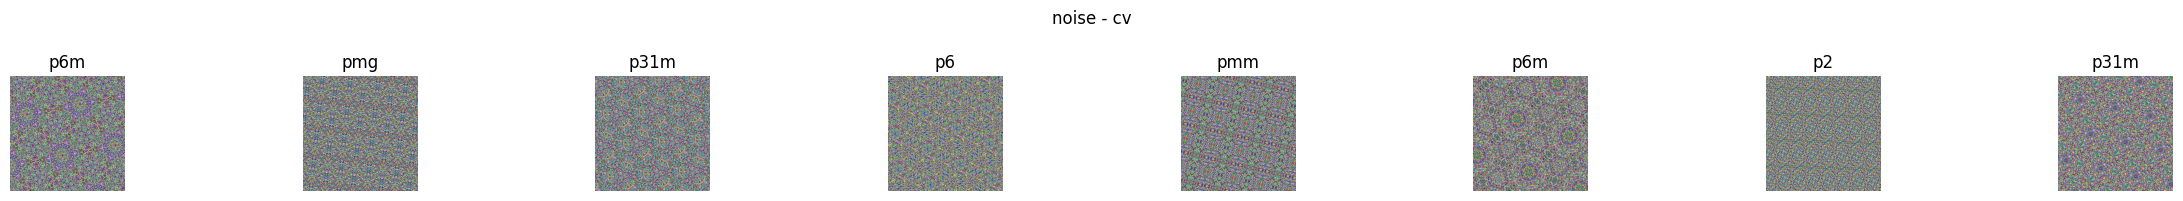

In [8]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
imagenet_ds = hdf5_dataset('../../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../../datasets/atom_v5_rot_200k.h5', folder='test', transform=transforms.ToTensor())
atom_dl = DataLoader(atom_ds, batch_size=64, shuffle=False, num_workers=4)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../../datasets/imagenet_atom_noise_v4_rot_10m_100k_subset.h5', folder='noise', transform=transforms.ToTensor())
noise_dl = DataLoader(noise_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

In [4]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[1,3])
# model

torch.Size([2, 17])


In [5]:
config = {
    'dataset': '10 million datasets',
    'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
    'optimizer': 'Adam',
    'scheduler': 'OneCycleLR',
}

NAME = '05242024-benchmark-resnet50_from_scratch-v5_10m'

# train

In [6]:
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, save_code=True, config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin
